In [15]:
import numpy as np
import matplotlib.pyplot as plt

def exponential_scaling(x):
    return np.sign(x) * np.exp(np.abs(x))

def reward_mod(reward):
        normalized_reward = (1-(reward / -16.2736044))-0.90
        if normalized_reward > 0:
            f_reward = exponential_scaling(normalized_reward*20)
        else:
            f_reward = (exponential_scaling(normalized_reward*3))
        return f_reward, (1-(reward / -16.2736044)) * 100




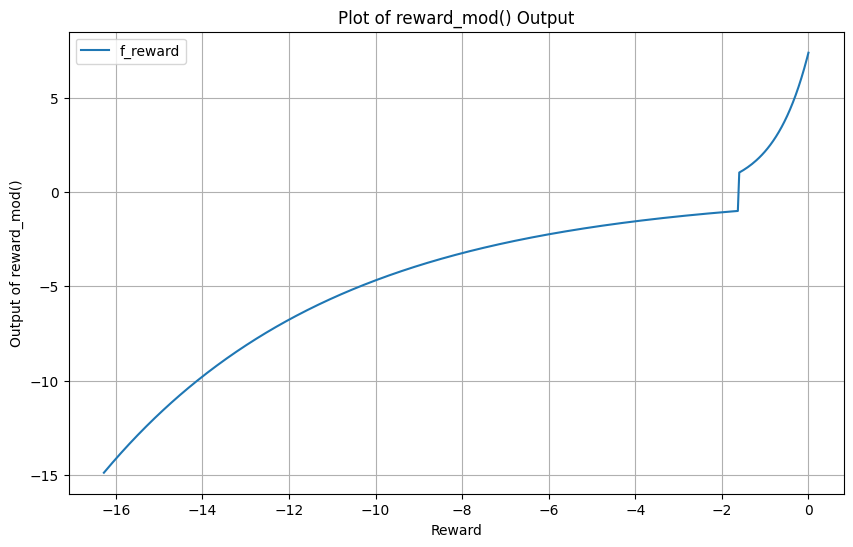

In [16]:


# Define the range for the x-axis
x_values = np.linspace(-16.2736044, 0, 500)
y_values = [reward_mod(x)[0] for x in x_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='f_reward')
plt.xlabel('Reward')
plt.ylabel('Output of reward_mod()')
plt.title('Plot of reward_mod() Output')
plt.grid(True)
plt.legend()
plt.show()


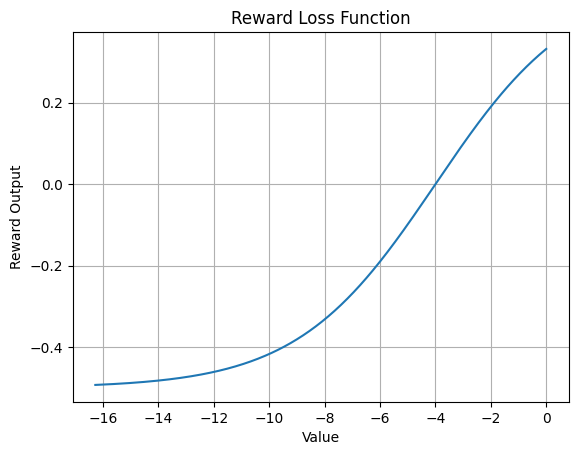

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def reward_loss(value):
    # Adjusting the midpoint of the sigmoid curve
    midpoint = -2
    normalized_value = (1 - ((value - midpoint) / midpoint))
    
    # Scaling the sigmoid function to make it 'smaller'
    scale_factor = 0.8  # Adjust this factor to scale the sigmoid
    return (1 / (1 + np.exp(-scale_factor * normalized_value)))-0.5

# Values range from -16.2736044 to 0
values = np.linspace(-16.2736044, 0, 500)
losses = [reward_loss(value) for value in values]

# Plotting
plt.plot(values, losses)
plt.grid(True)
plt.xlabel('Value')
plt.ylabel('Reward Output')
plt.title('Reward Loss Function')
plt.show()


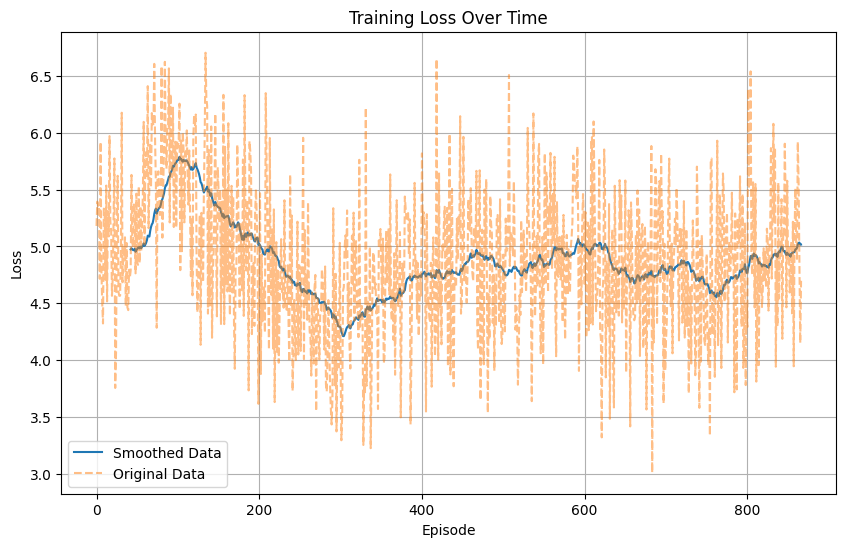

Episode 3500: average reward: -35.92
1/1 [==============================] - 0s 51ms/step


KeyboardInterrupt: 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from collections import deque
import time
import gym
import random
import datetime
import matplotlib.pyplot as plt
from IPython.display import clear_output


# Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        return random.sample(self.buffer, sample_size)

# log scaling for reward
def logarithmic_scaling(reward):
    if reward > 0:
        return np.log(1 + reward)
    elif reward < 0:
        return -np.log(1 - reward)
    else:
        return 0
    
def exponential_scaling(x):
    return np.sign(x) * np.exp(np.abs(x))

def reward_mod(value):
    # Adjusting the midpoint of the sigmoid curve
    midpoint = -2
    normalized_value = (1 - ((value - midpoint) / midpoint))
    
    # Scaling the sigmoid function to make it 'smaller'
    scale_factor = 0.8  # Adjust this factor to scale the sigmoid
    return (1 / (1 + np.exp(-scale_factor * normalized_value)))-0.5, (1-(value / -16.2736044)) * 100

# Create Model
def create_model(num_states, num_actions):
    inputs = Input(shape=(num_states,))

    # Add the first hidden layer with 32 units and ReLU activation
    layer1 = Dense(64, activation="relu")(inputs)
    # Add dropout to the first hidden layer
    dropout1 = Dropout(0.7)(layer1)

    # Add the second hidden layer with 64 units and ReLU activation
    layer2 = Dense(128, activation="relu")(dropout1)
    # Add dropout to the second hidden layer
    dropout2 = Dropout(0.7)(layer2)

    # Add the output layer with 'num_actions' units and tanh activation
    action = Dense(num_actions, activation="tanh")(dropout2)
    return Model(inputs=inputs, outputs=action)

def plot_live(data, title, ylabel):
    # Calculate the window size as 5% of the length of the data array
    window_size = int(len(data) * 0.05)
    # Ensure the window size is at least 1
    window_size = max(1, window_size)

    smoothed_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    # Plotting
    clear_output(wait=True)
    plt.figure(figsize=(10,6))
    plt.title(title)

    # Plot original data and smoothed data
    plt.plot(np.arange(window_size-1, len(data)), smoothed_data, label='Smoothed Data')
    plt.plot(data, label='Original Data', linestyle='--', alpha=0.5)

    plt.ylabel(ylabel)
    plt.xlabel('Episode')
    plt.grid(True)
    plt.legend()
    plt.show()


# Initialize Environment and Model
env = gym.make('Pendulum-v1', render_mode='human')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

model = create_model(num_states, num_actions)
model_target = create_model(num_states, num_actions)

# Learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True)
optimizer = Adam(learning_rate=lr_schedule)
loss_function = Huber()

# DQN parameters
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_max = 1.0
epsilon_interval = epsilon_max - epsilon_min
epsilon_random_frames = 50000
epsilon_greedy_frames = 1000000.0
batch_size = 32
max_steps_per_episode = 200
update_after_actions = 4
update_target_network = 10000
max_memory_length = 100000
buffer = ReplayBuffer(max_memory_length)

# Early Stopping
early_stopping_callback = EarlyStopping(monitor='loss', patience=10)

# Training loop
running_reward = 0
episode_count = 0
frame_count = 0


human_score_log = []
loss_log = []

while True:
    observation, _ = env.reset()
    state = np.array(observation, dtype=np.float32)
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            action = env.action_space.sample()
        else:
            action_probs = model.predict(state.reshape(1, -1))[0]
            action = np.clip(action_probs, env.action_space.low[0], env.action_space.high[0])

        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        next_state, reward, done, _, _ = env.step(action)

        modified_reward, human_score = reward_mod(reward)
        
        human_score_log.append(human_score)
        episode_reward += modified_reward

        next_state = np.array(next_state)

        buffer.add(state, action, reward, next_state, done)
        state = next_state

        if frame_count % update_after_actions == 0 and len(buffer.buffer) > batch_size:
            indices = np.random.choice(range(len(buffer.buffer)), size=batch_size)
            minibatch = [buffer.buffer[i] for i in indices]

            state_sample = np.array([x[0] for x in minibatch])
            action_sample = np.array([x[1] for x in minibatch])
            rewards_sample = np.array([x[2] for x in minibatch])
            next_state_sample = np.array([x[3] for x in minibatch])
            done_sample = np.array([x[4] for x in minibatch])

            future_rewards = model_target.predict(next_state_sample)
            updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards, axis=1)
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            with tf.GradientTape() as tape:
                q_values = model(state_sample)
                loss = loss_function(updated_q_values, q_values)
                loss_log.append(loss)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            model_target.set_weights(model.get_weights())

        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
        if running_reward > exponential_scaling(((1-(0 / -16.2736044))-0.92)*30)*0.98:
            print(f"Solved at episode {episode_count}: average reward: {running_reward:.2f}!")
            model.save('save/DQNSuccess.h5')
            break

        episode_count += 1

        if episode_count % 500 == 0:
            plot_live(loss_log, "Training Loss Over Time", "Loss")
            
        if episode_count % 500 == 0:
            print(f"Episode {episode_count}: average reward: {running_reward:.2f}")

        # Save Model
        if episode_count % 5000 == 0:
            model.save('save/model_episode_{}.h5'.format(episode_count))


In [ ]:
# Load the model
model = tf.keras.models.load_model('save/DQNSuccess.h5')

# Initialize the gym environment
env = gym.make('Pendulum-v1', render_mode='human')

num_episodes = 10  # Set the number of episodes you want to test

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        env.render()  # Comment this out if you don't need to visualize the environment
        observation, _ = env.reset()
        state = np.array(observation, dtype=np.float32)
        action_probs = model.predict(state.reshape(1, -1))[0]
        action = np.clip(action_probs, env.action_space.low[0], env.action_space.high[0])

        # Take the action and observe the new state and reward
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward

        state = next_state

    print(f'Episode: {episode+1}, Total Reward: {total_reward}')

env.close()


1/1 [==============================] - ETA: 0s

KeyboardInterrupt: 